
# 🩺 Predikcija dijabetesa 

Cilj ovog projekta je predikcija prisustva dijabetesa kod pacijenata na osnovu medicinskih parametara iz **PIMA Indian Diabetes** skupa podataka.

Dataset sadrži **768 zapisa** i **8 ulaznih atributa (feature-a)** koji predstavljaju osnovne kliničke pokazatelje svake osobe.  
Ciljna promenljiva (`Outcome`) ima dve klase:
- **0** → pacijent nije dijabetičar  
- **1** → pacijent ima dijabetes 


## 8 ulaznih atributa
| Atribut | Opis | Tip |
|----------|------|-----|
| **Pregnancies** | Broj trudnoća | numerički |
| **Glucose** | Nivo glukoze u krvi posle oralnog testa (mg/dL) | numerički |
| **BloodPressure** | Dijastolni krvni pritisak (mm Hg) | numerički |
| **SkinThickness** | Debljina kožnog nabora (mm) | numerički |
| **Insulin** | Nivo insulina u serumu (μU/mL) | numerički |
| **BMI** | Indeks telesne mase (*kg/m²*) | numerički |
| **DiabetesPedigreeFunction** | Genetski rizik zasnovan na porodičnoj istoriji | numerički |
| **Age** | Starost pacijenta (godine) | numerički |


---

## Putanje i pomoćne funkcije

In [13]:

from pathlib import Path
import json, pandas as pd, numpy as np
from IPython.display import display, Image

ROOT = Path(".")
EDA_SUMMARY = ROOT / "plots/eda_summary.json"
CV_JSON     = ROOT / "artifacts/cv_results.json"
TEST_JSON   = ROOT / "artifacts/test_metrics.json"

def show_img(path, width=None):
    p = Path(path)
    if p.exists():
        display(Image(filename=str(p), width=width))
    else:
        print(f"[nedostaje] {p}")


## EDA — (nedostajuće, balans klasa, korelacije)

In [14]:

if EDA_SUMMARY.exists():
    eda = json.loads(EDA_SUMMARY.read_text())
    rows = eda.get("rows")
    missing = pd.Series(eda.get("missing_ratio", {}), name="missing_ratio")
    class_bal = pd.Series(eda.get("class_balance", {}), name="ratio").rename(index={"0":"class_0","1":"class_1"})
    print("Broj uzoraka:", rows)
    display(missing.sort_values(ascending=False).to_frame())
    display(class_bal.to_frame())
else:
    print("Nedostaje eda_summary.json — preskočeno.")


Broj uzoraka: 768


,missing_ratio
Insulin,0.486979
SkinThickness,0.295573
Pregnancies,0.000000
Glucose,0.000000
BloodPressure,0.000000
BMI,0.000000
DiabetesPedigreeFunction,0.000000
Age,0.000000
Outcome,0.000000


,ratio
class_0,0.651042
class_1,0.348958



### Kako čitati histogram i box-plot
- **Histogram**: osa X = vrednosti, osa Y = broj uzoraka. Vidimo **oblik raspodele** i retke vrednosti.
- **Box-plot**: kutija = Q1–Q3 (srednjih 50%), linija = **medijana**, kružići = **outlieri** (van *Q1−1.5·IQR* i *Q3+1.5·IQR*).


### EDA slike — primeri

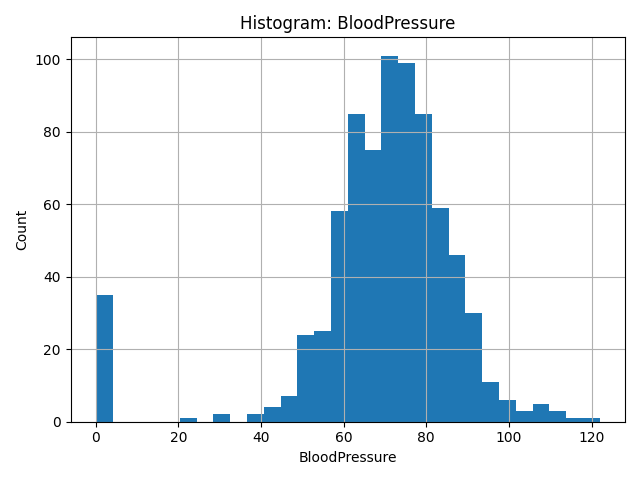

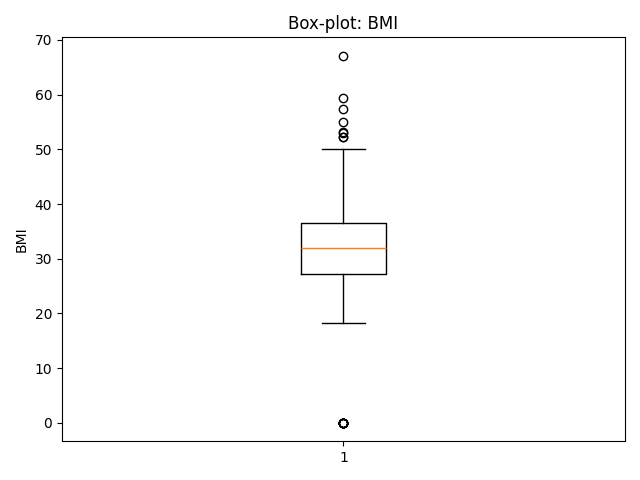

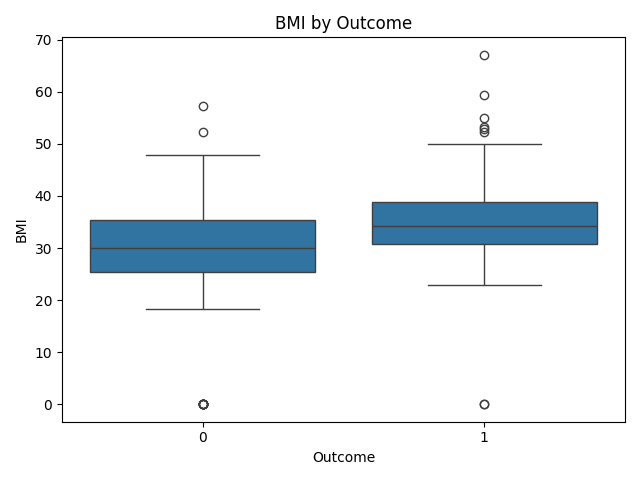

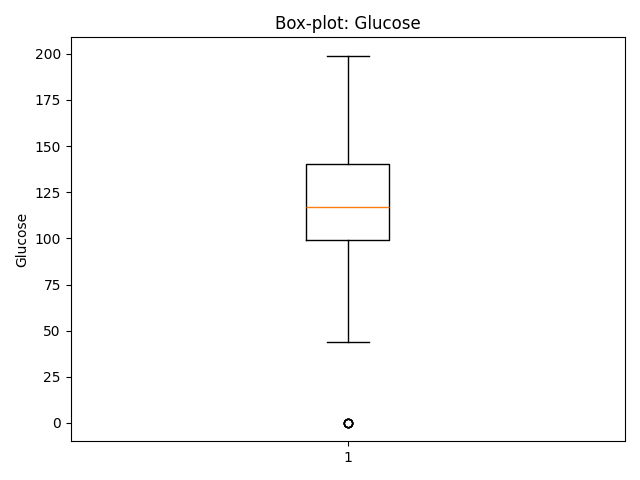

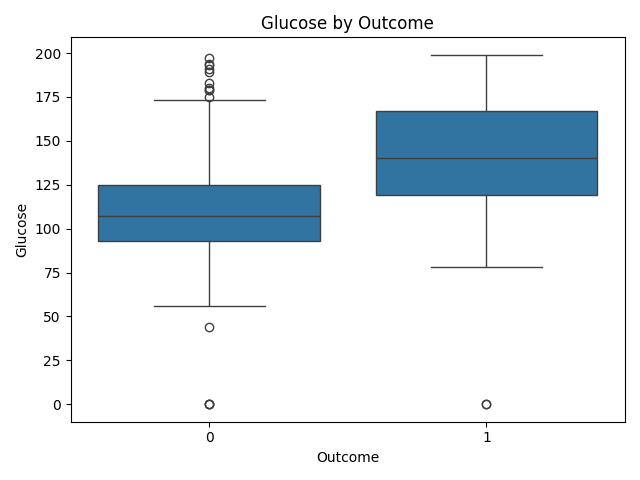

In [6]:

# Histogram (primer)
show_img("plots/hist_BloodPressure.png", width=650)

# Box-plot BMI (svi) i po klasama
show_img("plots/box_BMI.png", width=650)
show_img("plots/box_BMI_by_outcome.png", width=650)

# Box-plot Glucose (svi) i po klasama
show_img("plots/box_Glucose.png", width=650)
show_img("plots/box_Glucose_by_outcome.png", width=650)



**Tumačenje:**  
- **BMI by Outcome** i **Glucose by Outcome** pokazuju viši medijan u klasi 1 → ovi atributi **razlikuju klase**.  
- Pojedinačni box-plotovi otkrivaju outliere (npr. ekstremne BMI/glucose).  


### Positive rate po kvartilima 
Ovi grafikoni prikazuju pozitivnu stopu po kvartilima — drugim rečima, koliko procenata pacijenata u svakoj grupi ima dijabetes.

Kvartil deli podatke na četiri jednake grupe po vrednosti atributa:
1. kvartil → 25% najmanjih vrednosti
2. kvartil → sledećih 25%
3. kvartil → sledećih 25%
4. kvartil → 25% najvećih vrednosti.

U naslovima grafa vidiš raspon svakog kvartila (npr. (27.3, 32.0] znači BMI između 27.3 i 32.0).
Positive rate se odnosi na udeo obolelih (Outcome=1) u tom kvartilu.

Primer:
Ako u grupi BMI između 32 i 36 ima 100 pacijenata, a 45 njih ima dijabetes → positive rate = 0.45 (45%).

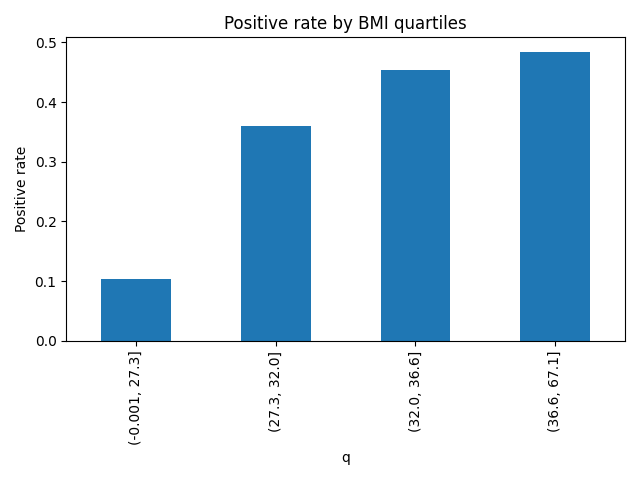

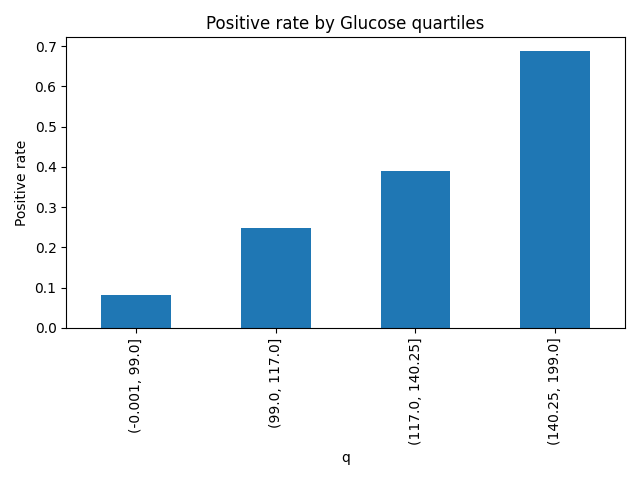

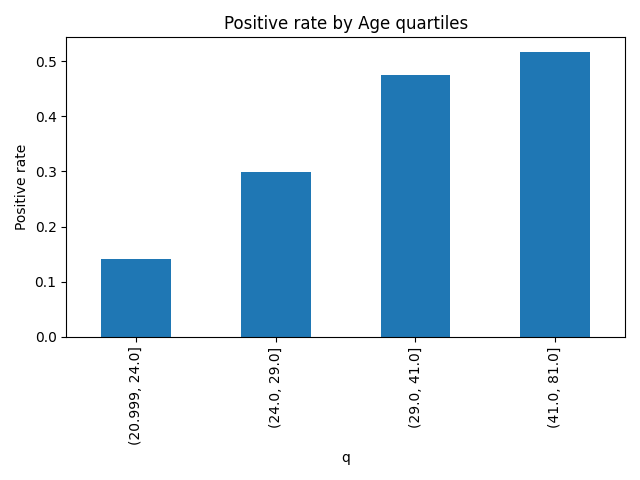

In [16]:

for name in ["plots/rate_by_quartiles_BMI.png", "plots/rate_by_quartiles_Glucose.png", "plots/rate_by_quartiles_Age.png"]:
    show_img(name, width=650)



**Čitanje:** stubci rastu ka višim kvartilima → veća vrednost atributa (posebno **Glucose**, zatim **BMI**, **Age**) ⇒ **veća verovatnoća** dijabetesa.


### Korelacije (Pearson i Spearman)

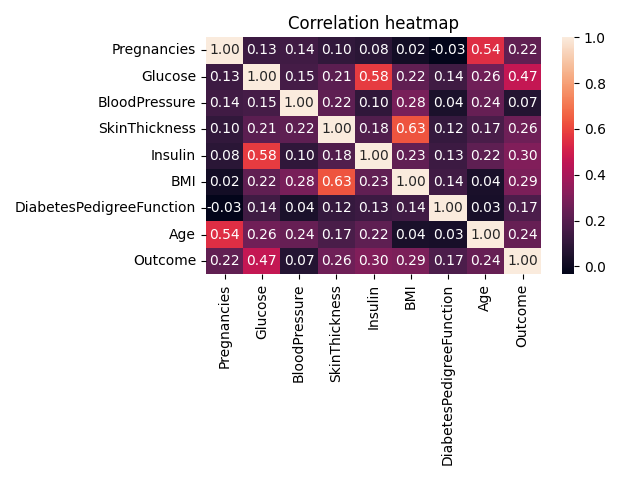

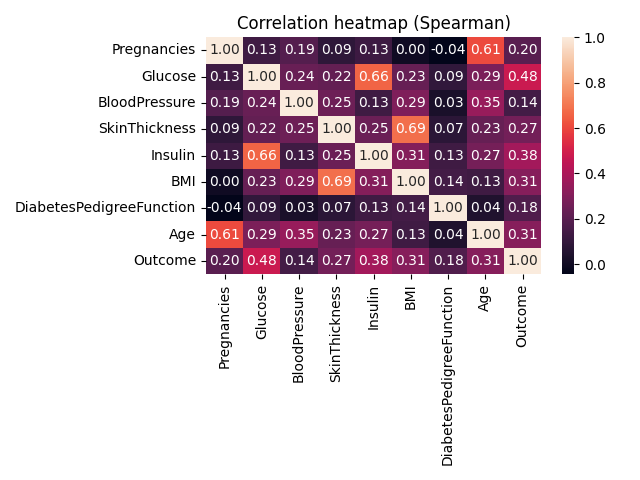

In [9]:

show_img("plots/corr_heatmap.png", width=650)
show_img("plots/corr_heatmap_spearman.png", width=650)



**Pearson** meri **linearni** odnos, **Spearman** meri **monotoni** odnos po rangovima.  
Najinformativnije relacije su `Glucose↔Outcome` (pozitivna), `BMI↔SkinThickness`, `Pregnancies↔Age`.  
U sažetku nema parova sa |r|>0.7 → ozbiljna kolinearnost **nije** problem.


Saznajemo koje promenljive stvarno nose signal (moć predikcije).
Ako dve promenljive imaju |r| > 0.7 (npr. BMI i SkinThickness), možeš izbaciti jednu da izbegneš kolinearnost — modelu ne treba duplikat informacije.


## Pretprocesiranje — šta se radi i zašto


- **Imputacija**: popuna `NaN` (Insulin/SkinThickness; nule tumačene kao missing).  
  - *Median* je robustan na outliere.  
  - *KNN* koristi najbliže pacijente za pametniju popunu.  
- **Standardizacija**: `StandardScaler` → svaka kolona ~ sredina 0, devijacija 1; ne dominiraju velike skale; ključno za **SVM/MLP**.  
- **Winsor (IQR klip)**: opcioni; odseca ekstremne vrednosti na *Q1−1.5·IQR* i *Q3+1.5·IQR* radi robusnosti.


## 5-fold CV — rezultati i izbor najboljeg modela

In [17]:

import pandas as pd, numpy as np, json
if CV_JSON.exists():
    cv = json.loads(CV_JSON.read_text())
    rows = []
    for name, d in cv.items():
        rows.append({
            "model": name,
            "cv_threshold": d.get("cv_threshold"),
            "roc_auc": d.get("roc_auc"),
            "pr_auc": d.get("pr_auc"),
            "accuracy": d.get("accuracy"),
            "precision": d.get("precision"),
            "recall": d.get("recall"),
            "f1": d.get("f1")
        })
    cv_df = pd.DataFrame(rows).sort_values("roc_auc", ascending=False).reset_index(drop=True)
    display(cv_df)
    best_name = cv_df.iloc[0]["model"]
    print("Najbolji po CV ROC-AUC:", best_name)
else:
    print("Nedostaje cv_results.json — preskočeno.")


,model,cv_threshold,roc_auc,pr_auc,accuracy,precision,recall,f1
0,svm,0.300773,0.835596,0.692985,0.749186,0.605634,0.803738,0.690763
1,lr,0.416691,0.833131,0.717837,0.719870,0.569536,0.803738,0.666667
2,rf,0.297500,0.821501,0.708269,0.729642,0.581081,0.803738,0.674510
3,mlp_64x32,0.359465,0.814509,0.666266,0.708469,0.556634,0.803738,0.657744
4,tabtr,0.500028,0.726005,0.641989,0.513029,0.400932,0.803738,0.534992
5,mlp_32x16,0.143573,0.496390,0.372922,0.355049,0.326996,0.803738,0.464865


Najbolji po CV ROC-AUC: svm



**Primarna metrika = ROC-AUC**. Veće je bolje i **ne zavisi od praga**.  
**best_name** je model sa najvećim prosečnim ROC-AUC preko 5 foldova (u tvojim rezultatima: **SVM**).


### Tjuniranje praga na CV predikcijama


- Iz **CV verovatnoća** traži se prag koji postiže **Recall ≥ 0.80**.  
- Ako to nije dostižno, bira se **prag sa maksimalnim F1**:  \(F1 = 2\frac{P\cdot R}{P+R}\).  
- Taj prag se **zamrzava** i koristi na testu.


## Test evaluacija (zamrznut prag)

In [18]:

if TEST_JSON.exists():
    tm = json.loads(TEST_JSON.read_text())
    display(pd.DataFrame([tm]))
else:
    print("Nedostaje test_metrics.json — preskočeno.")


,threshold,roc_auc,pr_auc,accuracy,precision,recall,f1,confusion_matrix
0,0.300773,0.8,0.661523,0.675325,0.525,0.777778,0.626866,"[[62, 38], [12, 42]]"


### Test grafici

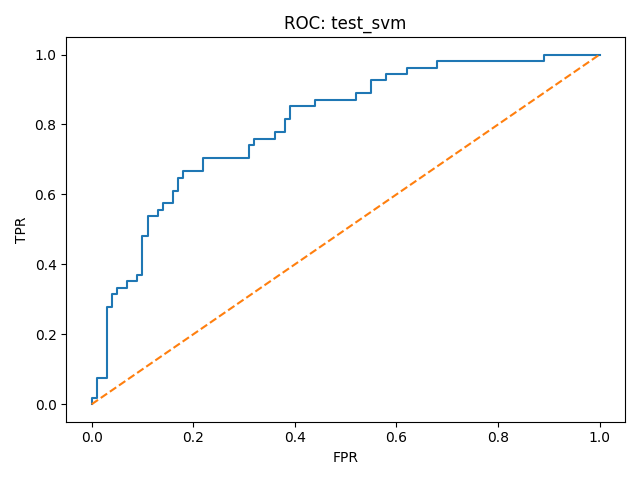

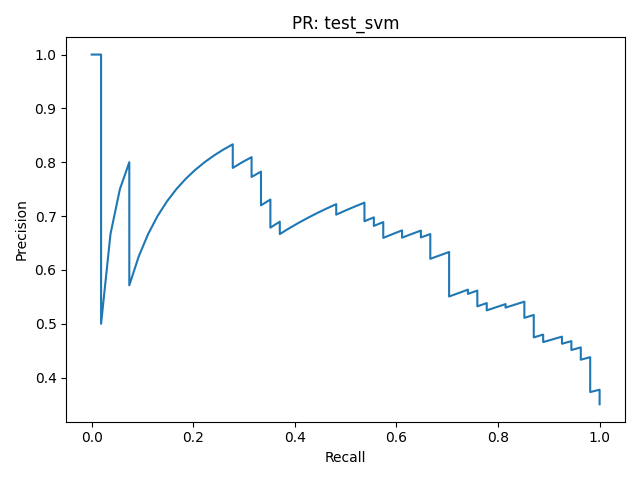

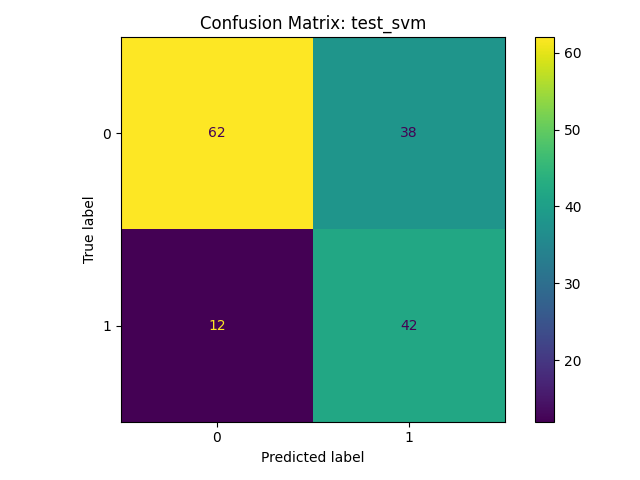

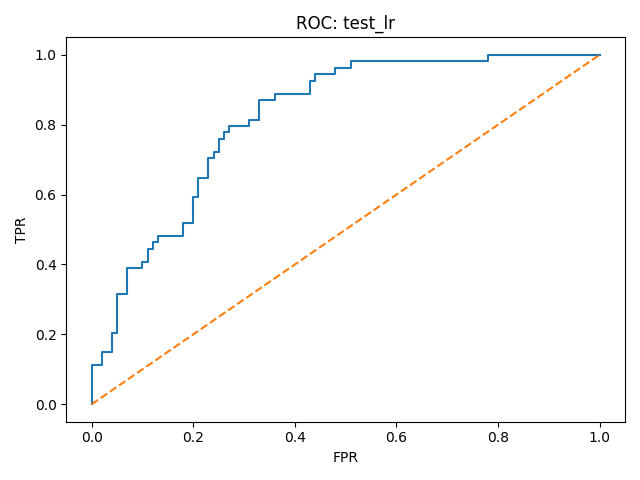

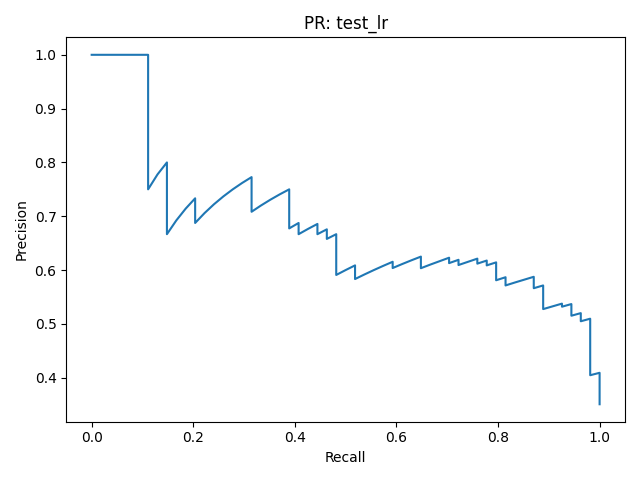

In [12]:

# ROC/PR i konfuziona za najbolji model (SVM)
show_img("artifacts/roc_test_svm.png", width=650)
show_img("artifacts/pr_test_svm.png",  width=650)
show_img("artifacts/cm_test_svm.png",  width=500)

# (opciono) ROC/PR za LR radi poređenja
show_img("artifacts/roc_test_lr.png", width=650)
show_img("artifacts/pr_test_lr.png",  width=650)



### Outlieri i nedostajuće
- **IQR outlieri**: vrednosti < Q1−1.5·IQR ili > Q3+1.5·IQR.  
- **Winsorizacija**: klip na granicama da smanji uticaj ekstremnih vrednosti.  
- **Nedostajuće** (`Insulin`, `SkinThickness`): 0 tretira se kao NaN, potom imputacija (median ili KNN).



### EDA → Treniranje
- Ako EDA pokaže kolinearnost (visok |r|), probaj **drop** jednog atributa i uporedi CV AUC.  
- Ako kvartili pokazuju monotoni rast pozitivne stope, očekuj da atribut bude važan prediktor.  
- Ako ima puno outliera, uključi **winsor=True** i uporedi rezultate.


### Hook: brzi eksperimenti

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from src.data import load_csv, FEATURES, TARGET

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

def _winsorize_iqr(X: np.ndarray, k: float = 1.5) -> np.ndarray:
    X = X.copy()
    q1 = np.nanpercentile(X, 25, axis=0)
    q3 = np.nanpercentile(X, 75, axis=0)
    iqr = q3 - q1
    lo = q1 - k*iqr
    hi = q3 + k*iqr
    return np.clip(X, lo, hi)

def build_preprocess_subset(feature_list, imputer="median", scale=True, winsor=False):
    if imputer == "median":
        imp = SimpleImputer(strategy="median")
    elif imputer == "knn":
        imp = KNNImputer(n_neighbors=5, weights="uniform")
    else:
        raise ValueError("imputer must be 'median' or 'knn'")

    steps = [("imputer", imp)]
    if winsor:
        steps.append(("winsor", FunctionTransformer(_winsorize_iqr, validate=False)))
    if scale:
        steps.append(("scaler", StandardScaler()))
    pipe = Pipeline(steps)
    return ColumnTransformer([("num", pipe, feature_list)], remainder="drop")

CSV = "data/diabetes.csv"

def cv_auc_for(df, imputer="median", winsor=False, drop_feats=None, scale=True):
    drop_feats = drop_feats or []
    feats = [f for f in FEATURES if f not in drop_feats]

    X = df.drop(columns=[TARGET]).copy()
    y = df[TARGET].astype(int).values

    pre = build_preprocess_subset(feats, imputer=imputer, scale=scale, winsor=winsor)
    pipe = Pipeline([
        ("pre", pre),
        ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_prob = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba")[:, 1]
    return roc_auc_score(y, y_prob)

dfa = load_csv(CSV, zero_as_missing=False)
dfb = load_csv(CSV, zero_as_missing=True)

summary = []
summary.append({"variant":"raw zeros / median / no-winsor", "auc": cv_auc_for(dfa, "median", False)})
summary.append({"variant":"zero->NaN / median / no-winsor", "auc": cv_auc_for(dfb, "median", False)})
summary.append({"variant":"zero->NaN / KNN / no-winsor",    "auc": cv_auc_for(dfb, "knn",    False)})
summary.append({"variant":"zero->NaN / median / winsor",    "auc": cv_auc_for(dfb, "median", True)})
summary.append({"variant":"drop SkinThickness",             "auc": cv_auc_for(dfb, "median", False, drop_feats=["SkinThickness"])})
summary.append({"variant":"drop BMI",                       "auc": cv_auc_for(dfb, "median", False, drop_feats=["BMI"])})

pd.DataFrame(summary).sort_values("auc", ascending=False).reset_index(drop=True)


,variant,auc
0,drop SkinThickness,0.826634
1,zero->NaN / median / no-winsor,0.821485
2,raw zeros / median / no-winsor,0.821216
3,zero->NaN / KNN / no-winsor,0.818840
4,drop BMI,0.812164
5,zero->NaN / median / winsor,0.791817



## Imputacija —  **Median** vs **KNN**

### Kada koristiti **Median**
- **Robustan** na outliere.  
- **Brz** i determinističan.  
- Pretpostavlja da su rupe *MCAR/MAR* i da je centralna vrednost dobra aproksimacija.  
- Mana: **ne koristi kontekst** drugih kolona → svima ubacuje istu vrednost po koloni.

### Kada koristiti **KNNImputer**
- Popunjava vrednost na osnovu **sličnih pacijenata** u prostoru atributa.  
- Može očuvati **korelacije** između kolona i dati realističnije raspodele.  
- Mane: sporiji, oslanja se na **euklidsko rastojanje** pre skaliranja → osetljiv na različite skale.

> U ovom pipeline-u KNN radi **pre** `StandardScaler`-a (jer skaler ne radi sa NaN), pa su distance na originalnim skalama. Ako želiš još korektnije distance za KNN, alternativa je dvoprolazno rešenje (npr. privremena median imputacija → skaliranje → KNN na standardizovanom prostoru → finalno skaliranje). To je složenije i izvan scope-a projekta, ali vredi pomenuti kao ideju.



### Statističke pretpostavke o nedostajućim podacima
- **MCAR** (*Missing Completely At Random*): rupe su "slučajne"; median je često dovoljan.  
- **MAR** (*Missing At Random*): rupe zavise od drugih kolona; **KNN** ima prednost.  
- **MNAR** (*Not At Random*): rupe nose informaciju (npr. Insulin nije meren kod specifičnih grupa); imputacija uvodi pristrasnost — prijavi ograničenje u radu.



### Brza dijagnostika uticaja imputacije (kvalitativno i kvantitativno)
- Kvalitativno: uporedi raspodele imputiranih vrednosti (histogrami pre/posle).  
- Kvantitativno: uporedi **CV ROC-AUC** modela posle imputacije (već imamo eksperimente).  
- Dodatno: proveri kako imputacija utiče na **korelacije** (`Glucose↔Insulin`, `BMI↔SkinThickness`).

In [1]:

# Demo: kakve vrednosti ubacuje median vs KNN za Insulin/SkinThickness
import pandas as pd, numpy as np
from src.data import load_csv, TARGET
from sklearn.impute import SimpleImputer, KNNImputer

df_raw = load_csv("data/diabetes.csv", zero_as_missing=True)
X = df_raw.drop(columns=[TARGET]).copy()

cols = ["Insulin","SkinThickness"]

X_med = X.copy()
X_knn = X.copy()

med_imp = SimpleImputer(strategy="median")
X_med[cols] = med_imp.fit_transform(X_med[cols])

knn_imp = KNNImputer(n_neighbors=5, weights="uniform")
X_knn[cols] = knn_imp.fit_transform(X_knn[cols])

summary = pd.DataFrame({
    "col": np.repeat(cols, 3),
    "stat": ["median","mean","std"]*2,
    "median_imp": [
        X_med["Insulin"].median(), X_med["Insulin"].mean(), X_med["Insulin"].std(),
        X_med["SkinThickness"].median(), X_med["SkinThickness"].mean(), X_med["SkinThickness"].std(),
    ],
    "knn_imp": [
        X_knn["Insulin"].median(), X_knn["Insulin"].mean(), X_knn["Insulin"].std(),
        X_knn["SkinThickness"].median(), X_knn["SkinThickness"].mean(), X_knn["SkinThickness"].std(),
    ],
})
summary


,col,stat,median_imp,knn_imp
0,Insulin,median,125.000000,155.548223
1,Insulin,mean,140.671875,153.368290
2,Insulin,std,86.383060,87.246984
3,SkinThickness,median,29.000000,29.153420
4,SkinThickness,mean,29.108073,29.153420
5,SkinThickness,std,8.791221,8.790942



**Tumačenje:**  
- **Median** će "skupiti" varijansu (više vrednosti oko jedne tačke).  
- **KNN** vraća širi, realističniji raspon jer koristi profile sličnih pacijenata.  


## Detaljnije o modelima, predikciji i EDA→treniranje vezama

**LR**: linearni decision boundary; interpretabilan.  
**RF**: ansambl stabala; hvata nelinearnosti; robustan na outliere.  
**SVM (RBF)**: maksimizuje marginu; RBF omogućava zakrivljene granice; zahteva standardizaciju.  
**MLP**: nelinearni slojevi; early stopping; traži standardizaciju.  
**TabTransformer**: koristi self‑attention da modelira međuzavisnosti atributa; potencijal, ali često traži više podataka.

**Predikcioni tok**: ulaz → imputacija → (opciono winsor) → standardizacija → SVM → verovatnoća → prag → 0/1.



**Čitanje grafika:**  
- **ROC**: TPR vs FPR; kriva bliže gornjem levom uglu je bolja; **AUC** = površina ispod.  
- **PR**: Precision vs Recall; važan kod neuravnoteženih klasa; vidi trade-off kako menjaš prag.  
- **Konfuziona**: TN/FP/FN/TP. Ako želiš **Recall ≥ 0.80**, spusti prag i prikaži novu matricu.


## Odgovori na pitanja


1) **Top 3 atributa**: iz EDA i bivarijantnih prikaza — **Glucose**, **BMI**, **Age**.  
2) **Positive rate po kvartilima**: raste sa kvartilom za **Glucose/BMI/Age**; najizraženije za **Glucose**.  
3) **Nule kao missing**: u `Insulin` i `SkinThickness` tretirane su kao `NaN` pa imputirane; efekat proveri kroz CV AUC pre/posle.  
4) **Standardizacija**: `scale=on` poboljšava **SVM/MLP** na validaciji jer su osetljivi na skalu.


## Kako pokrenuti front (Streamlit)


1. Trenira i snima artefakte:
```bash
python -m src.train --csv data/diabetes.csv --imputer median --out artifacts
```
2. Pokreni UI:
```bash
streamlit run app.py
```
Aplikacija učitava `artifacts/best_model.pkl` i prag iz `artifacts/test_metrics.json`.
